In [ ]:
! pip install tslearn

     |████████████████████████████████| 793 kB 5.2 MB/s 


In [ ]:
! pip install pyts

     |████████████████████████████████| 2.5 MB 5.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from pyts.transformation import ShapeletTransform
import pyts.datasets

In [ ]:
DS = 'ECG200'
X_train, X_test, y_train, y_test = pyts.datasets.fetch_ucr_dataset(dataset=DS, return_X_y=True)
Ori_test = X_test

In [ ]:
y_train

array([-1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,
        1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1])

In [ ]:
def label_encoder(training_labels, testing_labels):

    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)

    return y_train, y_test

y_train, y_test = label_encoder(y_train, y_test)

In [ ]:
y_train

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1])

In [ ]:
def get_shapelet(X_train, y_train, len_ts):
    a = int(len_ts * 0.3)
    b = int(len_ts * 0.5)
    c = int(len_ts * 0.7)
    st = ShapeletTransform(n_shapelets=100, window_sizes=[a, b, c],
                           random_state=42, sort=True)
    st.fit_transform(X_train, y_train)
    indices = pd.DataFrame(st.indices_)
    return indices

# category the shapelets by their label, res include 4 columns, the index, start index, end index, and the label
def shapelet_category(y_train, indices, label):
    labels = y_train[indices.iloc[:, 0]]
    labels = pd.DataFrame(labels)
    frames = [indices, labels]
    res = pd.concat(frames, axis=1)
    res.columns=["idx", "start_point", "end_point", "label"]
    res = res.groupby('label')
    res = res.get_group(label).head(1)
    res = np.array(res)
    return res

In [ ]:
len_ts = X_train.shape[1]
classes =np.unique(y_test)
nb_classes = len(classes)
print(X_train.shape, len_ts, classes)
idx_shapelets = get_shapelet(X_train, y_train, len_ts)  # index, start_point, end_point
shapelets = []
for i in classes:
    shapelets.append(shapelet_category(y_train, idx_shapelets, i))
print(shapelets)

(100, 96) 96 [0 1]
[array([[61, 27, 94,  0]]), array([[55, 13, 80,  1]])]


In [ ]:
shapelet_dic = {}
for cls in range(nb_classes):
    shapelet_dic[cls] = X_train[shapelets[cls][0][0]][shapelets[cls][0][1]:shapelets[cls][0][2]]

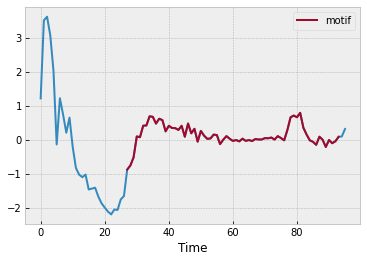

In [ ]:
plt.style.use('bmh')
cls = 0
plt.plot(X_train[shapelets[cls][0][0]], )
plt.plot(np.arange(shapelets[cls][0][1], shapelets[cls][0][2]),
         X_train[shapelets[cls][0][0], shapelets[cls][0][1]:shapelets[cls][0][2]], label = "motif")


plt.xlabel('Time', fontsize=12)
# plt.title('The shapelets', fontsize=14)
plt.legend()
plt.show()

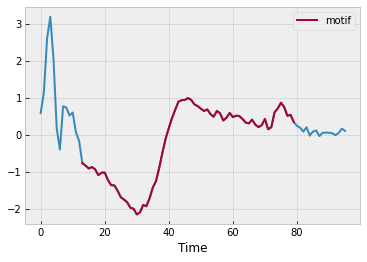

In [ ]:
plt.style.use('bmh')
cls = 1
plt.plot(X_train[shapelets[cls][0][0]],)
plt.plot(np.arange(shapelets[cls][0][1], shapelets[cls][0][2]),
         X_train[shapelets[cls][0][0], shapelets[cls][0][1]:shapelets[cls][0][2]], label = "motif")

plt.xlabel('Time', fontsize=12)
plt.legend()
plt.show()


# train & test data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

classifier = RandomForestClassifier()

def train(classifier, X_train, y_train, X_test):
  model = classifier
  model.fit(X_train, y_train)
  return model

model = train(classifier, X_train, y_train, X_test)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_preds = model.predict_proba(X_test)

In [ ]:
def target(instance):
  target = np.argsort(instance)[-2:-1][0]
  return target

def targets_generation(instances):
  targets= []
  for i in y_preds:
    res = target(i)
    targets.append(res)
  return targets

targets = targets_generation(y_preds) # store the target class we want to change to

In [ ]:
def eval(y_test, y_pred):
  f1 = f1_score(y_test, y_pred, average= 'micro')
  return f1
f1 = eval(y_test,y_pred)
f1

0.81

In [ ]:
y_test

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [ ]:
counterfactual_examples = []
def counterfacutal_generation(test_samples):
  for i in range(len(test_samples)):
    index, start, end = shapelets[targets[i]][0][0], shapelets[targets[i]][0][1], shapelets[targets[i]][0][2]
    test_samples[i][start:end] = X_train[index][start:end]
    counterfactual_examples.append(test_samples[i])
  return counterfactual_examples

In [ ]:
counterfactual_examples = counterfacutal_generation(X_test)

In [ ]:
_, X_test, _, _ = pyts.datasets.fetch_ucr_dataset(dataset=DS, return_X_y=True)

In [ ]:
y_test

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

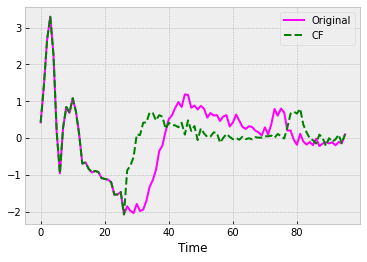

In [ ]:
plt.style.use('bmh')

plt.plot(X_test[0], label = 'Original', color='magenta')
plt.plot(counterfactual_examples[0], label = 'CF', ls='--', color='green')

plt.xlabel('Time', fontsize=12)
# plt.title('The shapelets', fontsize=14)
plt.legend()
plt.show()

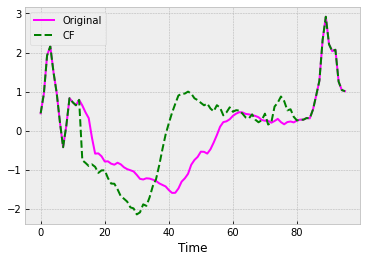

In [ ]:
plt.style.use('bmh')

plt.plot(X_test[4], label = 'Original', color='magenta')
plt.plot(counterfactual_examples[4], label = 'CF', ls='--', color='green')

plt.xlabel('Time', fontsize=12)
# plt.title('The shapelets', fontsize=14)
plt.legend()
plt.show()

In [ ]:
from scipy.spatial import distance
def getmetrics(x1,x2):
    x1 = [np.round(e, 3) for e in x1]
    x2 = [np.round(e, 3) for e in x2]

    l = [np.round(e1-e2,3) for e1,e2 in zip(x1,x2)]
    dist = distance.cityblock(x1,x2)
    sparsity = (len(l)-np.count_nonzero(l))/len(l)

    segnums = get_segmentsNumber(l)
    return dist, sparsity, segnums

def get_segmentsNumber(l4):
    flag, count = 0,0
    for i in range(len(l4)):
        if l4[i:i+1][0]!=0:
            flag=1
        if flag==1 and l4[i:i+1][0]==0:
            count= count+1
            flag=0
    return count

In [ ]:
counter_res = model.predict_proba(counterfactual_examples)

In [ ]:
target_probs = []
for i in range(len(counter_res)):
  target_prob = counter_res[i][targets[i]]
  target_probs.append(target_prob)

In [ ]:
res = []
for i in range(len(X_test)):
  dist, sparsity, segnums = getmetrics(X_test[i],counterfactual_examples[i])

  res.append(np.array([dist, sparsity, segnums, target_probs[i]]))
res = pd.DataFrame(res)
res.columns=['dist', 'sparsity', 'segnums', 'target_probs']

In [ ]:
res

,dist,sparsity,segnums,target_probs
0,41.927,0.302083,1.0,0.79
1,40.824,0.302083,1.0,0.81
2,43.485,0.302083,1.0,0.82
3,40.478,0.302083,1.0,0.83
4,50.202,0.302083,1.0,0.83
...,...,...,...,...
95,40.224,0.302083,1.0,0.79
96,38.152,0.302083,1.0,0.79
97,64.427,0.302083,1.0,0.92
98,25.146,0.302083,1.0,0.92


In [ ]:
res.to_csv(DS + '.csv')

In [ ]:
def check_fliplabel(counterfactual_examples):
  counter_res = model.predict(counterfactual_examples)
  f1 = eval(counter_res,targets)
  return f1
res = check_fliplabel(counterfactual_examples)
print("flip label rate " + str(res))

flip label rate 1.0
